In [23]:
import json
import jsondiff
import numpy as np
import matplotlib.pyplot as plt
import smopy
from numpy.random import default_rng
import scipy.stats
from scipy.spatial import distance

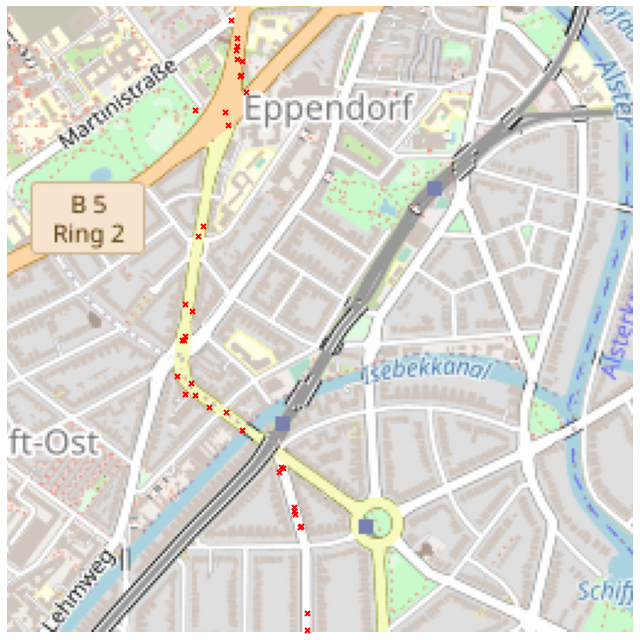

In [24]:
def extract_json_positions(data):
    '''
    Extract position tuples (latitude, longitude) from critical maps json.
    
    Parameters:
    data : dictonary
        json dictonary from critical maps website with n
        (longitude, latitude) tuples
    Returns:
    positions : numpy 2xn array
    '''
    locations = data['locations']
    positions = np.empty((0,2));
    for ident in locations:
        loc = locations[ident]
        positions=np.append(positions,[[loc['latitude']*1e-6,loc['longitude']*1e-6]],axis=0)
    return positions

def open_cm_log(path):
    ''' Open logged json in path, return json'''
    with open(path,'r') as f:
        data = json.load(f);
    return data

data = open_cm_log('cm_logs/20220624_202509.txt')
positions = extract_json_positions(data)
#mapHH = smopy.Map((53.55, 9.92, 53.6, 10.03), z=12)
#mapHH = smopy.Map((53.55, 9.94, 53.60, 9.97), z=12)
mapHH = smopy.Map(53.585, 9.9817, z=14)
positions_px_x,positions_px_y = mapHH.to_pixels(positions[:,0],positions[:,1])
ax = mapHH.show_mpl(figsize=(12, 9))
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ax.plot(positions_px_x,positions_px_y, 'xr', ms=5, mew=2);

In [8]:
#https://www.ipol.im/pub/art/2017/176/article.pdf
# An Unsupervised Algorithm for Detecting Good Continuation in Dot Patterns, Lezama et al.
b = 5 # number of nearest neighbours used for exploration, default in paper: 5
lam = 4 # porportion of the local window radius w.r.t. the triplet size, default in paper: 4
delta = 10*256/256 # minimum discrete precision of the domain
pos = [np.array([x,y]) for x,y in zip(positions_px_x,positions_px_y)]
pos = [p for p in pos if (min(xlim) <= p[0] <= max(xlim)) and
                                  (min(ylim) <= p[1] <= max(ylim))]
# Calculate distance maps
# https://stackoverflow.com/questions/48312205/find-the-k-nearest-neighbours-of-a-point-in-3d-space-with-python-numpy
D = distance.squareform(distance.pdist(pos))
N = len(pos)
closest = np.argsort(D, axis=1) #each line represents closest point indices

#ax = mapHH.show_mpl(figsize=(12, 9))
#for p in positions_px:
#    ax.plot(p[0],p[1], 'or', ms=10, mew=2);
def dist(p0,p1):
    ''' Cartesian distance between two points p0 and p1'''
    return distance.pdist([p0,p1])[0]
def triplet_error(r,R,n):
    '''
    Error of a triplet accordion according to eq. (1)
    r: distance between ideal (symmetric) point to near point
    R: radius of local window disk
    n: number of points in local window
    '''
    return 1-(1-r**2/R**2)**n

def maximum_error(k):
    '''
    Eq. 4
    k:
    '''
    return (1/(b*N*np.sqrt(N)))**(1/(k-2))

# Algorithm 1: Good Continuation detection
maximum_error_N = maximum_error(N)
# List including triplets indices + error
triplets = []
for i,pi in enumerate(pos):
    for j,pj in enumerate(pos):
        if D[i,j] < delta:
            continue
        R = lam * D[i,j]
        # Count number of points within local window with radius R around pi
        n = np.sum(D[0,1:] <= R)
        # Symmetric point to i w.r.t. j
        s_ij = pi + (pi-pj)
        # Iterate over b nearest neighbors of pi
        for k in closest[i,1:b+1]:
            pk = pos[k]
            e = triplet_error(dist(s_ij,pk),R,n)
            if e < maximum_error_N:
                # save triplets including error
                triplets.append((i,j,k,e))
print('Number of triplets:', len(triplets))
DT = np.full((len(triplets),len(triplets)),np.inf)
for s,st in enumerate(triplets):
    for t,tt in enumerate(triplets):
        # Check if triplets are adjacent
        if st[0:1] == tt[1:2] or st[1:2] == tt[0:1]:
            # Add sum of errrors
            DT[s,t] = st[3] + tt[3]

Number of triplets: 1062


In [14]:
# Number of triplets
NT = len(triplets)
# Floyd-Warshall with path reconstruction, 
# See https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm#Path_reconstruction
# and AlgorithmsNotesForProfessionals.pdf
DF = DT # minum distances
# next edge for shortest path, initialization: [[0, 1, 2, 3, ...], [0, 1, 2, 3, ...],...]
nextF =  np.tile(np.arange(NT),(NT,1))

for k in range(NT):
    for i in range(NT):
        for j in range(NT):
            if DF[i,j] > DF[i,k] + DF[k,j]:
                DF[i,j] = DF[i,k] + DF[k,j]
                nextF[i,j] = nextF[k,j]